In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from preprocess import Data_for_transformer_cnn, preprocess_data
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x, sublayer_output):
        return self.layer_norm(x + self.dropout(sublayer_output))


In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, ffn_hidden, dropout_rate):
        super().__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)
        self.attention_residual = ResidualBlock(d_model, dropout_rate)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.ReLU(),
            nn.Linear(ffn_hidden, d_model)
        )
        self.ffn_residual = ResidualBlock(d_model, dropout_rate)
        
    def forward(self, x, attention_mask=None, padding_mask=None):
        # Multi-head attention
        attn_output, _ = self.multihead_attention(
            query=x, key=x, value=x, attn_mask=attention_mask, key_padding_mask=padding_mask
        )
        x = self.attention_residual(x, attn_output)

        # Feed-forward
        ffn_output = self.feed_forward(x)
        x = self.ffn_residual(x, ffn_output)
        return x


In [5]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, ffn_hidden, input_dim, dropout_rate):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model, bias=False)
        
        # Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, ffn_hidden, dropout_rate)
            for _ in range(n_layers)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(d_model, 1)

    def create_padding_matrix(self, input_tensor):
        batch_size, seq_length, _ = input_tensor.size()
        row_sums = input_tensor.sum(dim=-1).to(input_tensor.device)
        padding_mask = (row_sums != 0).float().to(input_tensor.device)
        return padding_mask

    def forward(self, x):
        # Input projection
        
        x = self.input_projection(x)
                                                                                                                                                    
        # Create masks
        padding_mask = self.create_padding_matrix(x)

        # Permute for compatibility with nn.MultiheadAttention
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        
        # Pass through Transformer layers
        for layer in self.layers:
            x = layer(x, padding_mask=padding_mask)
        
        # Compute scores for each item
        output = self.output_layer(x)  # (seq_len, batch_size, 1)                                                                                            
        return output.permute(1, 0, 2)  # (batch_size, seq_len, 1)


In [6]:
# class Encoder(nn.Module):
#     def __init__(self, d_model, n_heads, n_layers, ffn_hidden, n_padding_layers, input_dim=136):
#         super(Encoder, self).__init__()
#         self.n_heads = n_heads
#         self.input_projection = nn.Linear(input_dim, d_model, bias=False)
#         self.n_padding_layers = n_padding_layers 

#         self.layers = nn.ModuleList([
#             nn.ModuleList([
#                 nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads),
#                 ResidualBlock(d_model),
#                 nn.Linear(d_model, ffn_hidden),
#                 nn.ReLU(),
#                 nn.Linear(ffn_hidden, d_model),
#                 ResidualBlock(d_model)
#             ]) for _ in range(n_layers)
#         ])

#         self.output_layer = nn.Linear(d_model, 1)

#     def create_padding_matrix(self, input_tensor):
#         batch_size, seq_length, _ = input_tensor.size()
        
#         row_sums = input_tensor.sum(dim=-1).to(input_tensor.device)  

#         padding_matrix = (row_sums != 0).float().to(input_tensor.device)  

#         return padding_matrix

#     def create_combined_mask(self, input_tensor):
#         batch_size, seq_length, _ = input_tensor.size()
        
#         attn_mask = torch.full((seq_length, seq_length), float('-inf')).to(input_tensor.device)
        
#         attn_mask.fill_diagonal_(0)
#         attn_mask = attn_mask.unsqueeze(0).repeat(batch_size * self.n_heads, 1, 1).to(input_tensor.device)
        
#         return attn_mask

#     def forward(self, x):
#         x = self.input_projection(x)
#         padding_mask = self.create_padding_matrix(x)  

#         attention_mask = self.create_combined_mask(x) 
 
#         x = x.permute(1, 0, 2)
#         for i, layer in enumerate(self.layers):
#             # if i < self.n_padding_layers:  
#             attn_output, _ = layer[0](x, x, x, key_padding_mask=padding_mask)
#             # else:  
#             #     attn_output, _ = layer[0](x, x, x, key_padding_mask=padding_mask, attn_mask=attention_mask)

#             x = layer[1](x, attn_output)  
            
#             ffn_output = F.relu(layer[2](attn_output)) 
#             ffn_output = layer[4](ffn_output)  
#             x = layer[5](x, ffn_output)  

#         output = self.output_layer(x)
        
#         return output.permute(1, 0, 2)

In [7]:
file_path = "datas_full_10k_1.pkl"

train_data = preprocess_data(file_path, num_docs=850, which=0, is_shuffle=True, for_cnn=False)
val_data = preprocess_data(file_path, num_docs=850, which=-1, is_shuffle=True, for_cnn=False)

In [8]:
batch_size = 128

train_dataset = Data_for_transformer_cnn(train_data)
val_dataset = Data_for_transformer_cnn(train_data)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [19]:
d_model = 512
n_heads = 4
n_layers = 2
ffn_hidden = 512
input_dim = 136
num_epochs = 100
lr = 1e-3

device = 'cuda'

model = Encoder(d_model=d_model, 
                n_heads=n_heads, 
                n_layers=n_layers, 
                ffn_hidden=ffn_hidden, 
                input_dim=input_dim, 
                dropout_rate=0.3
                ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma = 0.75)

In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 3226113


In [21]:
def cross_entropy(output, y, mask=None):
    """
    Compute cross-entropy loss for each document, ignoring padded documents.

    Args:
    - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
    - y (Tensor): True target labels, shape [batch_size, num_docs].
    - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                               shape [batch_size, num_docs].

    Returns:
    - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
    """
    output = output.squeeze(-1)  # output: [batch_size, num_docs]

    if mask is not None:
        # Set logits for padded documents to -inf
        output = output.masked_fill(~mask, -1e9)

    # Compute log-softmax over the class dimension
    log_softmax_output = torch.log_softmax(output, dim=-1)
    x_outputs = output / (torch.sum(output, dim = -1, keepdim = True) +1e-10)

    # Calculate the per-document cross-entropy loss
    loss = -torch.sum(y / (torch.sum(y, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
    # Final batch loss
    batch_loss = torch.mean(loss)  # Mean over all batch elements

    return batch_loss

In [22]:
def create_mask(inputs):
    """
    Create a mask for padded documents based on feature sums.

    Args:
    - inputs (Tensor): Input tensor of shape [batch_size, num_docs, num_features].

    Returns:
    - mask (Tensor): Boolean mask of shape [batch_size, num_docs].
    """
    return inputs.sum(dim=-1) != 0


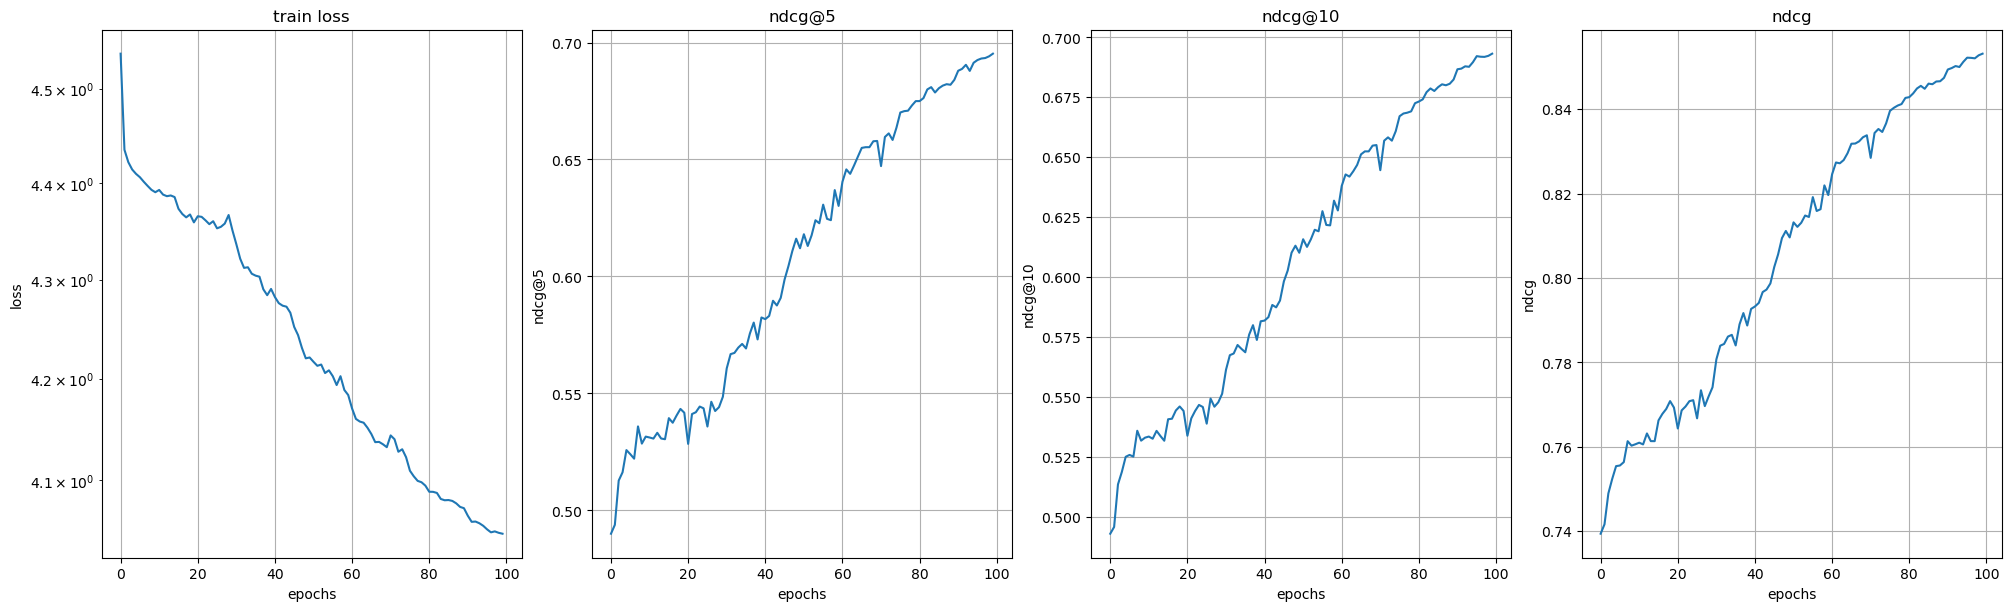

Epoch [100/100], Loss: 4.0480
Validation Loss: 9.5358, Avg NDCG: 0.8531 || NDCG@5 0.6952286643874358 || NDCG@10 0.693196454320419


: 

In [ ]:
from IPython.display import clear_output

nall, n5, n10, losses = [],[],[],[] 

for epoch in range(num_epochs):
    model.train()  
    total_loss = 0
    
    for batch in train_loader:
        inputs, targets = batch 

        inputs = inputs.float()
        mask = create_mask(inputs)
        outputs = model(inputs)

        loss = cross_entropy(outputs, targets, mask)
        
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()      
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    

    model.eval()
    val_loss = 0
    ndcg_scs = {5 : [],
                10 : [],
                'full' : []}

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch  
            inputs = inputs.float()

            outputs = model(inputs) 

            mask = inputs.sum(dim=2) != 0  

            valid_outputs = outputs[mask] 
            valid_targets = targets[mask] 
            loss = cross_entropy(valid_outputs, valid_targets)
            val_loss += loss.item()

            for i in range(inputs.size(0)):  
                query_mask = mask[i]  
                query_outputs = outputs[i][query_mask].squeeze()
                query_targets = targets[i][query_mask]

                if query_targets.numel() > 1:
                    
                    for i,k in enumerate([5,10,'full']):
                        c = None if k == 'full' else k
                        ndcg = ndcg_score(
                            [query_targets.cpu().numpy()],
                            [query_outputs.cpu().numpy()],
                        k = c)
                        ndcg_scs[k].append(ndcg)
                    

        avg_val_loss = val_loss / len(val_loader)
        avg_ndcg = sum(ndcg_scs['full']) / len(ndcg_scs['full']) if ndcg_scs['full'] else 0.0
        top5ndcg = sum(ndcg_scs[5]) / len(ndcg_scs[5]) if ndcg_scs[5] else 0.0
        top10ndcg = sum(ndcg_scs[10]) / len(ndcg_scs[10]) if ndcg_scs[10] else 0.0
        
        if epoch < 30:
            scheduler.step()
        elif epoch % 2 == 0:
            scheduler.step()
            
            
        
        
        losses.append(avg_loss)
        nall.append(avg_ndcg)
        n5.append(top5ndcg)
        n10.append(top10ndcg)
        if epoch >= 1 : 
            fig, ax = plt.subplots(1,4,figsize = (20,6), constrained_layout=True)
            
            ax[0].set_yscale('log')
            ax[0].plot(np.arange(epoch+1), losses)
            ax[0].set_xlabel('epochs')
            ax[0].set_ylabel('loss')
            ax[0].set_title('train loss')
            ax[0].grid(True)
            
            ax[1].plot(np.arange(epoch+1), n5)
            ax[1].set_xlabel('epochs')
            ax[1].set_ylabel('ndcg@5')
            ax[1].set_title('ndcg@5')
            ax[1].grid(True)
            
            ax[2].plot(np.arange(epoch+1), n10)
            ax[2].set_xlabel('epochs')
            ax[2].set_ylabel('ndcg@10')
            ax[2].set_title('ndcg@10')
            ax[2].grid(True)
            
            ax[3].plot(np.arange(epoch+1), nall)
            ax[3].set_xlabel('epochs')
            ax[3].set_ylabel('ndcg')
            ax[3].set_title('ndcg')
            ax[3].grid(True)
            clear_output()
            plt.show()
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}, Avg NDCG: {avg_ndcg:.4f} || NDCG@5 {top5ndcg} || NDCG@10 {top10ndcg}')

torch.save(model.state_dict(), 'encoder_model.pth')

In [27]:
print(np.max(nall),np.max(n5),np.max(n10))
print(len(nall))

0.8471044258039294 0.6860645472394383 0.6819733974530761
70


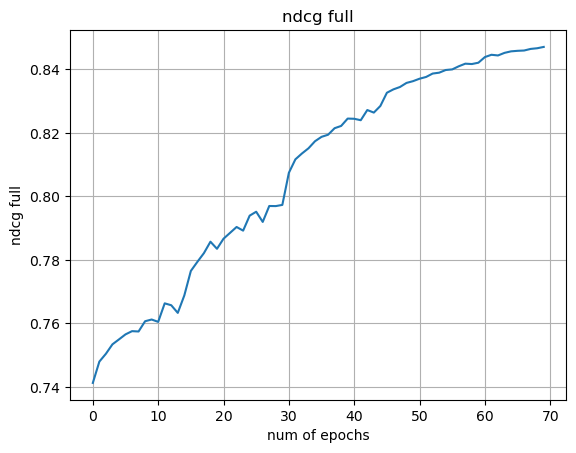

: 

In [ ]:
plt.plot(nall)
plt.grid()
plt.title('ndcg full')
plt.xlabel('num of epochs')
plt.ylabel('ndcg full')
plt.savefig('ndcg full')
plt.show()

